In [88]:
import requests
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import scipy.optimize as spo
def sird(x, gamma=1, eta=1, beta=1):
    return gamma*(1 - np.exp(- eta * x)) - beta*x
def gomp(x, beta=1, alpha=1, x_tilde=1):
    return beta*x - alpha*x*np.log((x + 0.0001) / x_tilde)

In [134]:
# Extract data from ECDC: https://www.ecdc.europa.eu/en/publications-data/data-daily-new-cases-covid-19-eueea-country
url = "https://opendata.ecdc.europa.eu/covid19/nationalcasedeath_eueea_daily_ei/csv/data.csv"
# Extract from https://github.com/CSSEGISandData/COVID-19
url2 = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [135]:
data2 = pd.read_csv(url2)
data2.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/6/22,3/7/22,3/8/22,3/9/22,3/10/22,3/11/22,3/12/22,3/13/22,3/14/22,3/15/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7623,7626,7630,7636,7639,7640,7641,7643,7645,7646
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3482,3483,3483,3483,3484,3485,3485,3485,3485,3486
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,6855,6857,6858,6860,6861,6861,6862,6864,6866,6868
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,151,151,152,152,152,152,152,152,152,152
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1900,1900,1900,1900,1900,1900,1900,1900,1900,1900


In [ ]:
data = pd.read_csv(url)
data.head()

In [29]:
data.dateRep.tail(100)

22182    13/05/2020
22183    12/05/2020
22184    11/05/2020
22185    10/05/2020
22186    09/05/2020
            ...    
22277    08/02/2020
22278    07/02/2020
22279    06/02/2020
22280    05/02/2020
22281    04/02/2020
Name: dateRep, Length: 100, dtype: object

In [117]:
# Process data
countries = data.countriesAndTerritories.unique()
countries

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden'], dtype=object)

In [182]:
data2["Country/Region"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Gua

In [257]:
START_DATE = "2020-01-22"
END_DATE = "2020-05-16"
WINDOW = 6 # days
def get_data2(country):
    y = data2[data2["Country/Region"] == country].iloc[:, 4:].sum(axis=0)
    dates = pd.to_datetime(data2.columns[4:], format="%m/%d/%y")
    cumdeaths = pd.Series(index=dates[1:], data=y.values.flatten()[1:])
    deaths = pd.Series(index=dates[1:], data=np.diff(y.values.flatten()))
    if country == "China":
        deaths = deaths[~((deaths > 1000))]
    cumdeaths = deaths.cumsum()
    deaths = deaths.rolling(WINDOW, center=True).mean()
    country = pd.DataFrame(index=dates[1:], data={"rollDeaths": deaths, "cumDeaths": cumdeaths})
    country = country[START_DATE:END_DATE]
    country = country.dropna()
    return country

def get_data(country: str):

    country = data[data.countriesAndTerritories == country]
    country.index = pd.to_datetime(country.dateRep, format="%d/%m/%Y")
    country = country.sort_index()
    country = country[START_DATE:END_DATE]
    country["rollDeaths"] = country.deaths.rolling(WINDOW, center=True).mean()
    country["cumDeaths"] = country.rollDeaths.cumsum()
    country["rollDeathsNorm"] = country["rollDeaths"] / country["cumDeaths"].max()
    country["cumDeathsNorm"] = country["cumDeaths"] / country["cumDeaths"].max()
    country = country.dropna()
    return country

11.0


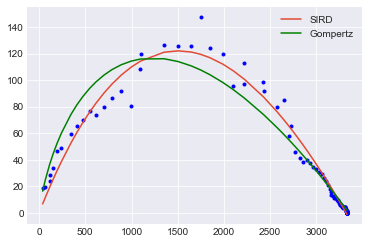

In [251]:
plt.style.use('seaborn-darkgrid')
country_data = get_data2("China")
x, y = country_data.cumDeaths, country_data.rollDeaths
sird_min_params = (10, 1e-6, 0.001) # gamma, eta, beta
sird_max_params = (10000, 1e-2, 1)
gomp_min_params = (0.01, 0.001, 0.01) # beta, alpha, x_tilde
gomp_max_params = (10, 1., 1.)


popt, pcov = spo.curve_fit(sird, x, y, bounds=(sird_min_params, sird_max_params))
popt_gomp, pcov_gomp = spo.curve_fit(gomp, x, y, bounds=(gomp_min_params, gomp_max_params))

plt.plot(x, y, ".", color="#0000ff")
plt.plot(x, sird(x, *popt), label="SIRD")
plt.plot(x, gomp(x, *popt_gomp), label="Gompertz", color="#008000")
plt.legend()

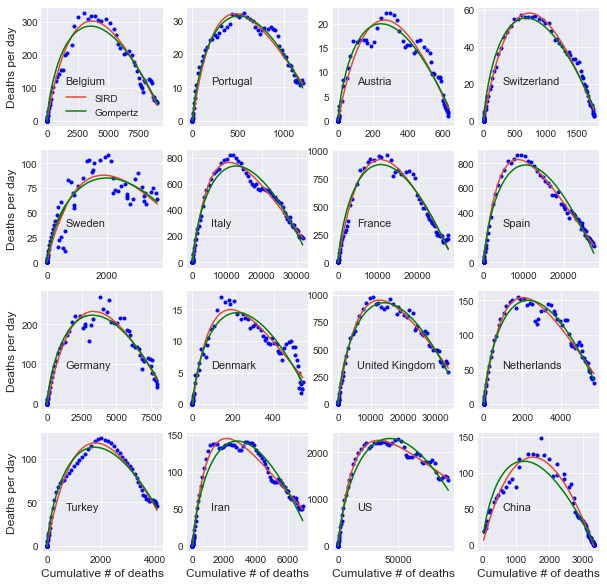

In [262]:
f, axs = plt.subplots(4,4,figsize=(10,10))
subset = ['Belgium', 'Portugal',  'Austria', 
       'Switzerland', 'Sweden',  'Italy', 'France', 'Spain', 'Germany','Denmark', 
          "United Kingdom", 'Netherlands', "Turkey", "Iran", "US", "China"]
for n, country in enumerate(subset):
    if n > 15:
        break
    i = int(n / 4)
    j = n % 4
    plt.sca(axs[i, j])
    country_data = get_data2(country)
    x, y = country_data.cumDeaths, country_data.rollDeaths
    sird_min_params = (10, 1e-6, 0.001) # gamma, eta, beta
    sird_max_params = (10000, 1e-2, 1)
    gomp_min_params = (0.01, 0.001, 0.01) # beta, alpha, x_tilde
    gomp_max_params = (10, 1., 1.)


    popt, pcov = spo.curve_fit(sird, x, y, bounds=(sird_min_params, sird_max_params))
    popt_gomp, pcov_gomp = spo.curve_fit(gomp, x, y, bounds=(gomp_min_params, gomp_max_params))

    plt.plot(x, y, ".", color="#0000ff")
    plt.plot(x, sird(x, *popt), label="SIRD")
    plt.plot(x, gomp(x, *popt_gomp), label="Gompertz", color="#008000")
    xmin, xmax = axs[i, j].get_xlim()
    ymin, ymax = axs[i, j].get_ylim()
    x_alpha = 0.80
    y_alpha = 0.65
    
    xloc = xmin * x_alpha + xmax * (1-x_alpha)
    yloc = ymin * y_alpha + ymax * (1-y_alpha)
    plt.text(xloc, yloc, country, fontsize=11)
    if j == 0:
        plt.ylabel("Deaths per day")
    if i == 3:
        plt.xlabel("Cumulative # of deaths")
    if n == 0:
        plt.legend()
plt.savefig("../figures/Gompertz_vs_SIRD.pdf")

In [209]:
y = data2[data2["Country/Region"] == "China"].iloc[:, 4:].sum(axis=0)
dates = pd.to_datetime(data2.columns[4:], format="%m/%d/%y")
deaths = pd.Series(index=dates[1:], data=np.diff(y.values.flatten()))

# deaths.loc["04-2020"]

2020-04-17    1290
dtype: int64